<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbers from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

In [1]:
"""
Import Statements
"""

# Base
from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load('en_core_web_sm')

In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/main/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [3]:
(shops['coffee_shop_name'] == 'Summermoon Coffee Bar ').value_counts()

False    7516
True      100
Name: coffee_shop_name, dtype: int64

In [4]:
shops['star_rating'] = shops['star_rating'].apply(lambda x: float(x[:4].strip()))

In [8]:
def clean_data(doc):
    
    non_alpha = '[^a-zA-Z]'
    multi_white_spaces = "[ ]{2,}"
    
    doc = re.sub(non_alpha, ' ', doc)
    doc = re.sub(multi_white_spaces, " ", doc)
    
    return doc.lower().strip()

shops['clean_text'] = shops['full_review_text'].apply(clean_data)

In [9]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,clean_text
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0,check in love love loved the atmosphere every ...
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0,listed in date night austin ambiance in austin...
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0,check in listed in brunch spots i loved the ec...
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0,very cool decor good drinks nice seating howev...
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0,check in they are located within the northcros...


In [10]:
STOP_WORDS = nlp.Defaults.stop_words.union(['checkin', 'coffee', 'shop', 'place', 'nt', 'm', 've', 's', 'austin', 't'])

In [12]:
# nested list that stores all tokens from all docs
tokens = []
for doc in nlp.pipe(shops['clean_text']):
    
    # store tokens from individual docs
    doc_tokens = []

    # iter through the tokens of the doc
    for token in doc:
        # provide stopword and punctuation filters on our tokens
        if ((token.is_punct == False) and (token.text.lower() not in STOP_WORDS) and (token.pos_ != 'PRON')):
            # store doc's tokens in list
            # case normalize our tokens
            doc_tokens.append(token.lemma_.lower())

    # store doc_tokens in our master list    
    tokens.append(doc_tokens)

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [14]:
# assign new token list to shops dataframe
shops['tokens'] = tokens

In [18]:
good_mask = shops['star_rating']>3
bad_mask = ~good_mask
# create a rating col that say good coffee shop is 1 and bad coffee shop is 0
shops.loc[good_mask, 'rating'] = 1 
shops.loc[bad_mask, 'rating'] = 0

In [20]:
def count(tokens):
    """
    Calculates some basic statistics about tokens in our corpus (i.e. corpus means collections text data)
    """
    # stores the count of each token
    word_counts = Counter()
    
    # stores the number of docs that each token appears in 
    appears_in = Counter()

    total_docs = len(tokens)

    for token in tokens:
        # stores count of every appearance of a token 
        word_counts.update(token)
        # use set() in order to not count duplicates, thereby count the num of docs that each token appears in
        appears_in.update(set(token))

    # build word count dataframe
    temp = zip(word_counts.keys(), word_counts.values())
    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # rank the the word counts
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # calculate the percent total of each token
    wc['pct_total'] = wc['count'].apply(lambda token_count: token_count / total * 100)

    # calculate the cumulative percent total of word counts 
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    # create dataframe for document stats
    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    
    # merge word count stats with doc stats
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs * 100)

    return wc.sort_values(by='rank')

In [22]:
wc_good = count(shops[good_mask]['tokens'])
wc_good.head(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
170,good,2949,4414,1.0,1.655962,1.655962,48.029316
107,great,2514,3494,2.0,1.310814,2.966776,40.944625
104,t,2149,3453,3.0,1.295432,4.262208,35.000000
1,check,2686,2942,4.0,1.103725,5.365932,43.745928
165,like,1683,2442,5.0,0.916144,6.282076,27.410423
0,love,1613,2137,6.0,0.801720,7.083796,26.270358
369,come,1482,1988,7.0,0.745821,7.829617,24.136808
355,time,1346,1782,8.0,0.668537,8.498154,21.921824
19,drink,1278,1736,9.0,0.651280,9.149434,20.814332
91,try,1333,1716,10.0,0.643777,9.793211,21.710098


In [23]:
wc_bad = count(shops[bad_mask]['tokens'])
wc_bad.head(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
117,t,856,1670,1.0,2.195895,2.195895,57.994580
6,good,648,1003,2.0,1.318852,3.514747,43.902439
2,like,596,946,3.0,1.243902,4.758649,40.379404
79,order,435,764,4.0,1.004589,5.763238,29.471545
84,come,452,650,5.0,0.854690,6.617927,30.623306
189,time,425,619,6.0,0.813927,7.431855,28.794038
20,drink,363,613,7.0,0.806038,8.237893,24.593496
35,check,489,527,8.0,0.692956,8.930849,33.130081
49,food,326,509,9.0,0.669288,9.600137,22.086721
122,great,348,472,10.0,0.620636,10.220773,23.577236


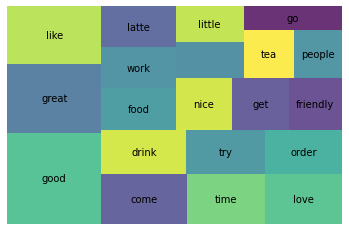

In [204]:
wc = count(shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [ ]:
def get_sentiment(rating): 
    """
    Accepts a string data type star review and returns a numerical score of 1 or 0 for the review sentiment. 
    Parameters
    ----------
    rating: string or object
    Returns
    -------
    sentiment score: boolean 
    """
    # strip out the text and convert string number into float point value
    num_rating = float(rating[:2])
    # assign sentiment numerically 
    if num_rating >= 4: 
        # 1 means positive sentiment
        return 1
    else:
        # 0 means negative sentiment
        return 0 

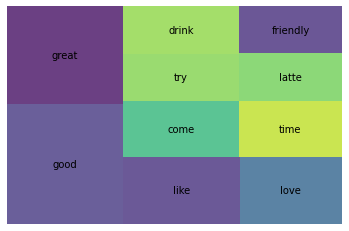

In [205]:
wc_good_top10 = wc_good[wc_good['rank'] <= 10]

squarify.plot(sizes=wc_good_top10['pct_total'], label=wc_good_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

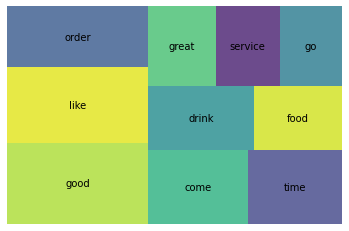

In [206]:
wc_bad_top10 = wc_bad[wc_bad['rank'] <= 10]

squarify.plot(sizes=wc_bad_top10['pct_total'], label=wc_bad_top10['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

